In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [2]:
train = '/home/studio-lab-user/chest-xray-pneumonia/data/train'
val = '/home/studio-lab-user/chest-xray-pneumonia/data/val'
test = '/home/studio-lab-user/chest-xray-pneumonia/data/test'

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [4]:
train_dt = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    brightness_range = (1.2,1.5),
    horizontal_flip = True
)
val_dt = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./225)
test_dt = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./225)

In [5]:
train_data = train_dt.flow_from_directory(
    train,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)
val_data = train_dt.flow_from_directory(
    val,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)
test_data = train_dt.flow_from_directory(
    test,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 628 images belonging to 2 classes.


## Building Model

In [6]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)
mobilenet.trainable = False

In [7]:
EPOCH = 50
inputs = tf.keras.Input(shape = (IMG_HEIGHT, IMG_WIDTH,3))
pretrained_model = mobilenet(inputs , training = False)
dense = tf.keras.layers.Dense(1024, activation = 'relu')(pretrained_model)
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(dense)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy' , tf.keras.metrics.AUC(name = 'auc')]
)
history = model.fit(
    train_data,
    validation_data = val_data,
    batch_size = BATCH_SIZE,
    epochs = EPOCH,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True )
                ]
)

Epoch 1/50
163/163 [==============================] - 92s 549ms/step - loss: 0.0839 - accuracy: 0.9657 - auc: 0.9944 - val_loss: 0.4105 - val_accuracy: 0.8750 - val_auc: 0.9609
Epoch 2/50
163/163 [==============================] - 88s 541ms/step - loss: 0.0816 - accuracy: 0.9689 - auc: 0.9944 - val_loss: 0.7286 - val_accuracy: 0.6875 - val_auc: 1.0000
Epoch 3/50
163/163 [==============================] - 88s 540ms/step - loss: 0.0839 - accuracy: 0.9676 - auc: 0.9942 - val_loss: 1.2191 - val_accuracy: 0.6250 - val_auc: 0.9375
Epoch 4/50
163/163 [==============================] - 89s 543ms/step - loss: 0.0708 - accuracy: 0.9732 - auc: 0.9954 - val_loss: 0.2853 - val_accuracy: 0.8750 - val_auc: 0.9375
Epoch 5/50
163/163 [==============================] - 89s 543ms/step - loss: 0.0682 - accuracy: 0.9734 - auc: 0.9960 - val_loss: 0.2598 - val_accuracy: 0.9375 - val_auc: 0.9688
Epoch 6/50
163/163 [==============================] - 88s 538ms/step - loss: 0.0770 - accuracy: 0.9712 - auc: 0.994

In [16]:
true_lables = test_data.labels
pred_lables = np.squeeze(np.array(model.predict(test_data) >=0.5,dtype = int))
cm = confusion_matrix(true_lables, pred_lables)

20/20 [==============================] - 10s 503ms/step


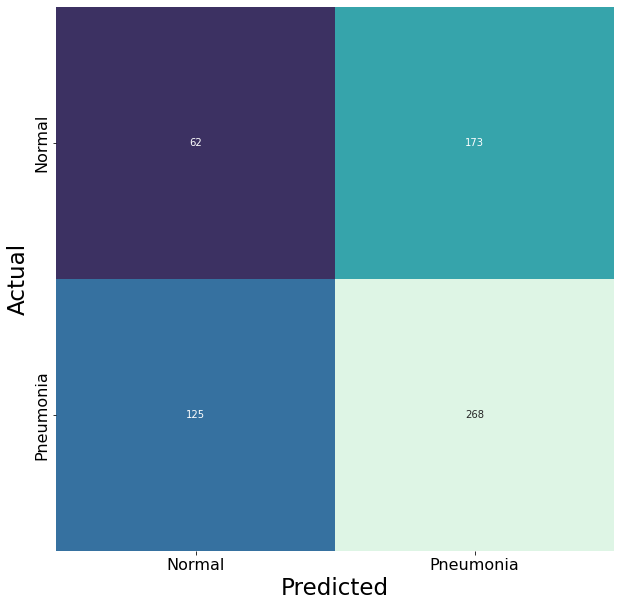

In [25]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot = True, fmt = 'g', vmin = 0, cmap = 'mako', cbar = False)
plt.xlabel('Predicted', fontsize = 23)
plt.ylabel('Actual', fontsize = 23)
plt.xticks(np.arange(2) + 0.5,['Normal','Pneumonia'], fontsize = 16)
plt.yticks(np.arange(2) + 0.5,['Normal','Pneumonia'], fontsize = 16)
plt.show()

In [18]:
result = model.evaluate(test_data, verbose = 0)
accuracy = result[1]
auc = result[2]

In [19]:
tn, fp,fn,tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

In [20]:
print('Accuracy: {:.2f}'.format(accuracy))
print('ACC: {:.2f}'.format(auc))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))

Accuracy: 0.88
ACC: 0.95
Precision: 0.61
Recall: 0.68
